In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import warnings
warnings.simplefilter('ignore')
import os
import numpy as np

In [2]:
# Read the CSV
heart = pd.read_csv("cleaned_cardio.csv")
heart.head()

,age,height,weight,ap_hi,ap_lo,cardio,BMI,gender_1,gender_2,cholesterol_1,...,cholesterol_3,gluc_1,gluc_2,gluc_3,smoke_0,smoke_1,alco_0,alco_1,active_0,active_1
0,50.0,66.0,136.0,110,80,0,21.948577,0,1,1,...,0,1,0,0,1,0,1,0,0,1
1,55.0,61.0,187.0,140,90,1,35.329481,1,0,0,...,1,1,0,0,1,0,1,0,0,1
2,52.0,65.0,141.0,130,70,1,23.461065,1,0,0,...,1,1,0,0,1,0,1,0,1,0
3,48.0,67.0,180.0,150,100,1,28.188906,0,1,1,...,0,1,0,0,1,0,1,0,0,1
4,48.0,61.0,123.0,100,60,0,23.238108,1,0,1,...,0,1,0,0,1,0,1,0,1,0


In [3]:
# Define variables
y = heart["cardio"]
target_names = ["negative", "positive"]
X = heart.drop("cardio", axis=1)
X2 = X.values
X2

array([[ 50.,  66., 136., ...,   0.,   0.,   1.],
       [ 55.,  61., 187., ...,   0.,   0.,   1.],
       [ 52.,  65., 141., ...,   0.,   1.,   0.],
       ...,
       [ 52.,  72., 231., ...,   1.,   1.,   0.],
       [ 61.,  64., 158., ...,   0.,   1.,   0.],
       [ 56.,  67., 158., ...,   0.,   0.,   1.]])

In [4]:
# Split data to test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=42)

In [5]:
# Perform XG Boost
import xgboost as xgb
from xgboost import XGBClassifier
# fit model no training data
model = XGBClassifier(probability = True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.7431203358208955

In [6]:
# GridSearch for XGBoost
from sklearn.model_selection import GridSearchCV

params_xg = {'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            }

grid_xg = GridSearchCV(model, param_grid = params_xg, n_jobs=-1)
grid_xg.fit(X_train, y_train)
print("Best Hyper Parameters:\n", grid_xg.best_params_)
prediction_xg = grid_xg.predict(X_test)

# Print Accuracy
from sklearn import metrics

accuracy_xg = metrics.accuracy_score(prediction_xg, y_test)
print("Accuracy: ", accuracy_xg)

Best Hyper Parameters:
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8}
Accuracy:  0.7430037313432836


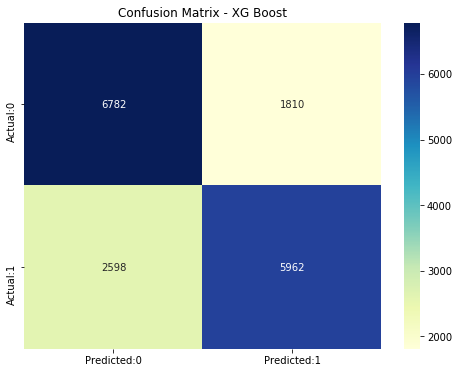

In [8]:
# Perform Confusion Matrix on XG Boost
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_xg)
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
figure1 = plt.figure(figsize = (8,6))
plt.title("Confusion Matrix - XG Boost")
figure1.savefig("Confusion_Matrix_XGB.png")
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [9]:
# Calculate Classification report
from sklearn.metrics import classification_report

class_report = classification_report(y_test, prediction_xg, target_names=target_names, output_dict = True)
df = pd.DataFrame(class_report).transpose()
df_to_html = df.to_html()
print(class_report)
print(df_to_html)

{'negative': {'precision': 0.7230277185501066, 'recall': 0.7893389199255121, 'f1-score': 0.7547295793456488, 'support': 8592}, 'positive': {'precision': 0.7671127123005661, 'recall': 0.6964953271028037, 'f1-score': 0.7301004163605193, 'support': 8560}, 'accuracy': 0.7430037313432836, 'macro avg': {'precision': 0.7450702154253364, 'recall': 0.7429171235141578, 'f1-score': 0.7424149978530841, 'support': 17152}, 'weighted avg': {'precision': 0.745029091364002, 'recall': 0.7430037313432836, 'f1-score': 0.7424379728185553, 'support': 17152}}
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>f1-score</th>
      <th>precision</th>
      <th>recall</th>
      <th>support</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>negative</th>
      <td>0.754730</td>
      <td>0.723028</td>
      <td>0.789339</td>
      <td>8592.000000</td>
    </tr>
    <tr>
      <th>positive</th>
      <td>0.730100</td>
      <td>0.767113</td>
      <td>

In [10]:
# Discuss the accuracy and Sensitivity of the file
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',
'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',
'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',
'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',
'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'‘\n',
'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',
'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',
'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.7430037313432836 
 The Missclassification = 1-Accuracy =  0.25699626865671643 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.6964953271028037 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.7893389199255121 
 Positive Predictive value = TP/(TP+FP) =  0.7671127123005661 ‘
 Negative predictive Value = TN/(TN+FN) =  0.7230277185501066 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  3.3062363814736404 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.3845048878697597


In [11]:
# Find the best model
best_xg = grid_xg.best_estimator_
best_xg

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=10, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', probability=True,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.8, verbosity=1)

With 0.1 threshold the Confusion Matrix is  
 [[ 534 8058]
 [  45 8515]] 
 with 9049 correct predictions and 45 Type II errors( False Negatives) 

 Sensitivity:  0.9947429906542056 Specificity:  0.06215083798882681 



With 0.2 threshold the Confusion Matrix is  
 [[1976 6616]
 [ 292 8268]] 
 with 10244 correct predictions and 292 Type II errors( False Negatives) 

 Sensitivity:  0.9658878504672898 Specificity:  0.22998137802607077 



With 0.3 threshold the Confusion Matrix is  
 [[4191 4401]
 [1010 7550]] 
 with 11741 correct predictions and 1010 Type II errors( False Negatives) 

 Sensitivity:  0.8820093457943925 Specificity:  0.48777932960893855 



With 0.4 threshold the Confusion Matrix is  
 [[5840 2752]
 [1827 6733]] 
 with 12573 correct predictions and 1827 Type II errors( False Negatives) 

 Sensitivity:  0.7865654205607476 Specificity:  0.6797020484171322 





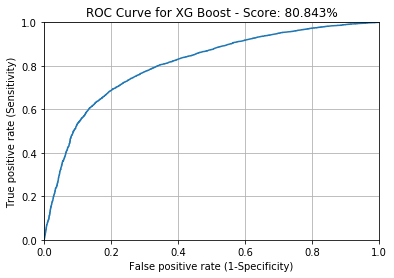

In [18]:
# ROC Curve
from sklearn.preprocessing import binarize

for i in range(1,5):
   cm2=0
   y_pred_prob_yes=best_xg.predict_proba(X_test)
   y_pred2=binarize(y_pred_prob_yes,i/10)[:,1]
   cm2=confusion_matrix(y_test,y_pred2)
   print ('With',i/10,'threshold the Confusion Matrix is ','\n',cm2,'\n',
           'with',cm2[0,0]+cm2[1,1],'correct predictions and',cm2[1,0],'Type II errors( False Negatives)','\n\n',
         'Sensitivity: ',cm2[1,1]/(float(cm2[1,1]+cm2[1,0])),'Specificity: ',cm2[0,0]/(float(cm2[0,0]+cm2[0,1])),'\n\n\n')

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
AUROC_Score_XG = roc_auc_score(y_test,y_pred_prob_yes[:,1])
score_xg = "{0:.3%}".format(AUROC_Score_XG)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve for XG Boost - Score: ' + str(score_xg))
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)
plt.savefig("ROC_Curve_XGBoost.png")

In [13]:
# Use pickle to have user inputs
import pickle

pkl_xg_filename = "pickle_xg.pkl"
with open(pkl_xg_filename, "wb") as file:
    pickle.dump(best_xg, file)
    
with open(pkl_xg_filename, "rb") as file:
    pickle_model_xg = pickle.load(file)

pickle_model_xg

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=10, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', probability=True,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.8, verbosity=1)

In [14]:
# Test the model
import numpy as np

new_user_input = np.array([[61,62,205,130,80,37.49,1,0,0,0,1,1,0,0,1,0,1,0,0,1]])

best_xg_score = pickle_model_xg.score(X_test, y_test)
perc_score_xg = 100*best_xg_score
print("Test Score: {:.2f} %".format(perc_score_xg))
predict_xg = pickle_model_xg.predict(new_user_input)
predict_xg

Test Score: 74.30 %


array([1], dtype=int64)